<a name="gr"></a>
# Gesture Recognition

When we talk about gestures, we could understand two types of gestures (see [Lecture 2 - Gestural interaction](https://github.com/bcaramiaux/GMI/blob/master/course-slides/Lecture2-Gestural-Interaction.pdf)): a posture or a temporal gesture. 

A posture is a static gesture such as:
<div style="width:200px;">![gesture](http://blog.clubcarlson.com/wp-content/uploads/2014/04/shutterstock_96934004-1024x731.jpg)</div>

A gesture is temporal meaning that it involves a trajectory in a the physical space:
<div style="width:200px;">![gesture](http://www.samsung.com/ph/smarttv/common/guide_book_3p_si/img/hand1.png)</div>

In the following we consider the dataset from the dollar1-recognizer (which are temporal gestures):
<div style="width:300px; margin: 0 auto;">![onedol](http://depts.washington.edu/madlab/proj/dollar/unistrokes.gif)</div>


In [4]:
from Lecture4lib.utils import load_one_dollar_ds

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
dataset, labels = load_one_dollar_ds()

In [7]:
len(dataset)

4800

In [8]:
import numpy as np
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

Number of gestures per class is **300**

<a name="gr_visualising"></a>
## Visualising dataset

In [9]:
gesture = 0

In [10]:
dataset, labels = load_one_dollar_ds(gesture)

In [11]:
len(dataset)

300

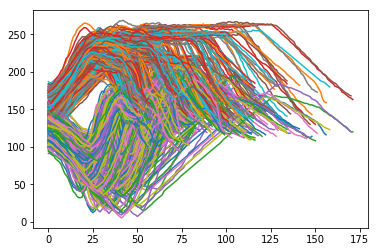

In [12]:
for g in dataset:
    plot(g)

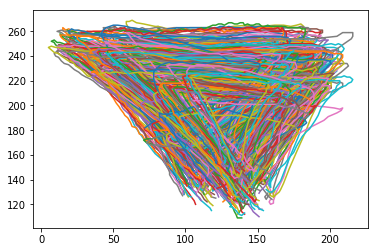

In [13]:
for g in dataset:
    plot(g[:,0], g[:,1])

In [14]:
from Lecture4lib.utils import mean_gesture, std_gesture

In [15]:
g = mean_gesture(gesture)

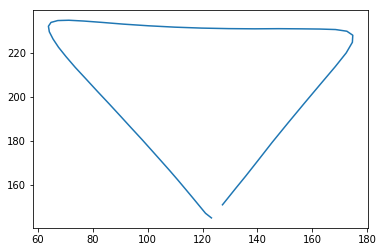

In [16]:
plot(g[:,0], g[:,1])

In [17]:
mean_g = mean_gesture(gesture)
std_g = std_gesture(gesture)

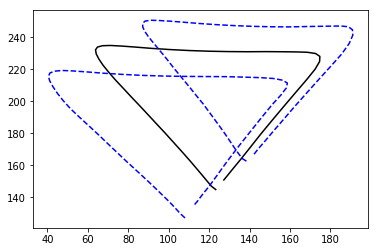

In [18]:
plot(mean_g[:,0], mean_g[:,1], '-k')
plot(mean_g[:,0] + std_g[:,0], mean_g[:,1] + std_g[:,1], '--b')
plot(mean_g[:,0] - std_g[:,0], mean_g[:,1] - std_g[:,1], '--b')

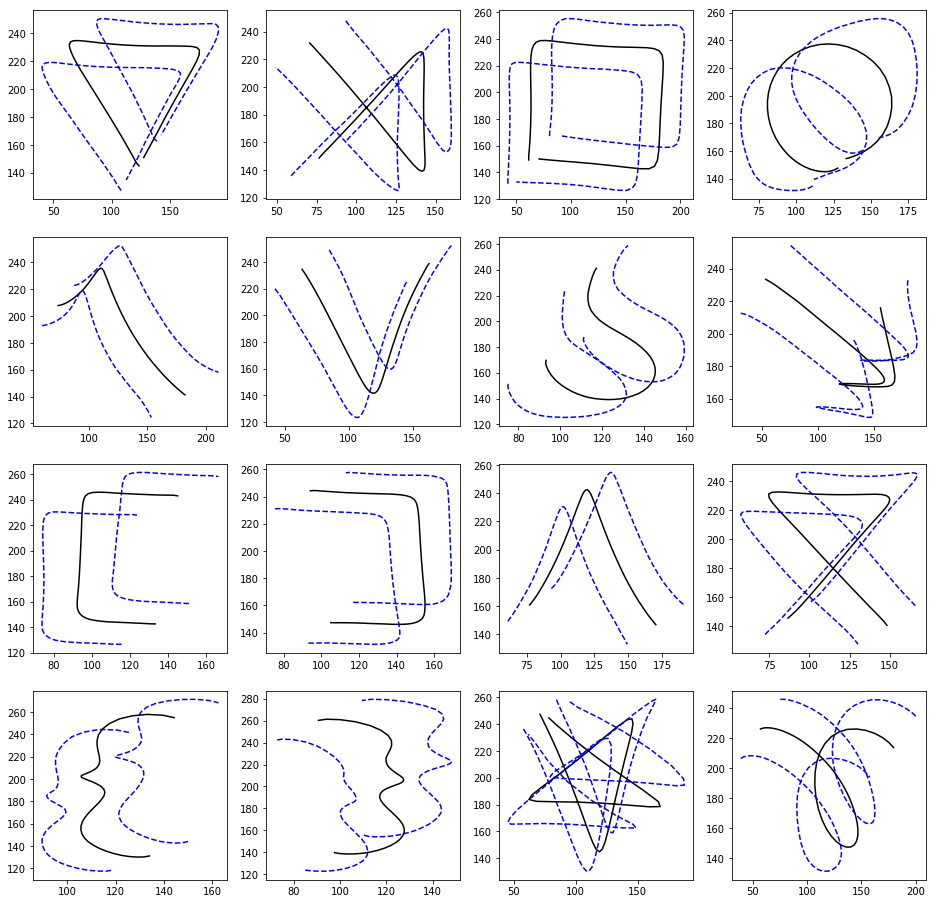

In [19]:
figure(figsize=(16,16))
for k in range(0,16):
    mean_g = mean_gesture(k)
    std_g = std_gesture(k)
    subplot(4,4,k+1)
    plot(mean_g[:,0], mean_g[:,1], '-k')
    plot(mean_g[:,0] + std_g[:,0], mean_g[:,1] + std_g[:,1], '--b')
    plot(mean_g[:,0] - std_g[:,0], mean_g[:,1] - std_g[:,1], '--b')

<a name="gr_training_testing"></a>
## Training and Testing a Classifier

### The case of SVM

Let's get the gesture data such as all of them have the same size:

In [21]:
dataset, labels = load_one_dollar_ds(resample=True)

In [22]:
dataset.shape

(4800, 50, 2)

In [23]:
dataset = np.resize(dataset, (4800, 100))

In [24]:
dataset.shape

(4800, 100)

In [25]:
from sklearn import svm
from sklearn.model_selection import StratifiedKFold

In [27]:
classifier = svm.SVC(kernel='linear');

num_tests = 20
splitter = StratifiedKFold(n_splits = num_tests)
all_scores = []

for train_index, test_index in splitter.split(dataset, labels):
    X_train, y_train, X_test, y_test = dataset[train_index], labels[train_index], dataset[test_index], labels[test_index]
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    all_scores.append(score)

print('Mean score with SVM: {:.2f}%'.format(np.mean(all_scores)*100.0))
print('  standard deviation: {:.2f}%'.format(np.std(all_scores)*100.0))

Mean score with SVM: 99.17%
  standard deviation: 0.99%


### Comparing SVM with other Classifiers

In machine learning, we usually compare various models in order to pick the best one for a particular application. Model comparison is usually done through cross-validation (see above for details about cross-validation). In the context of this course, for the sake of comparison, we compare classification accuracy for two classifiers: the already presented **Linear SVM** (in sklearn: `svm.SVC(kernel='linear')`) and the (very famous) **k-Nearest Neighbour** (in sklearn: `neighbors.KNeighborsClassifier()`)

If you don't know kNN, this classification algorithm assigns a label to a new input vector from a majority vote of its k nearest neighbors:

![kNN](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png "kNN")

Let's import kNN from sklearn and re-import svm:

In [28]:
from sklearn import neighbors
from sklearn import svm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Comparing classifiers

In [29]:
classifiers = ['SVM', 'kNN']
all_scores = {'SVM': [], 'kNN': []}

In [30]:
splitter = StratifiedKFold(n_splits=10)

In [31]:
dataset, labels = load_one_dollar_ds(resample=True)
dataset = np.resize(dataset, (4800, 100))

count_tests = 0
labels = np.array(labels)
for train_index, test_index in splitter.split(dataset, labels):

    # select training and testing datasets
    X_train = dataset[train_index]
    y_train = labels[train_index]
    X_test = dataset[test_index]
    y_test = labels[test_index]   
    
    count_tests += 1
    
    for clf in classifiers:
        
        # declare classifier
        if (clf=='SVM'): classifier = svm.SVC(kernel='linear')
        elif (clf=='kNN'): classifier = neighbors.KNeighborsClassifier()

        # train classifier
        classifier.fit(X_train, y_train)

        # compute score on testing dataset and store it
        score = classifier.score(X_test, y_test)
        all_scores[clf].append(score)  
    
        # print score
        print('Test', count_tests, ':', clf, 'score: %.2f%%'%(score*100)) 


Test 1 : SVM score: 92.92%
Test 1 : kNN score: 90.42%
Test 2 : SVM score: 99.58%
Test 2 : kNN score: 98.96%
Test 3 : SVM score: 99.79%
Test 3 : kNN score: 97.50%
Test 4 : SVM score: 99.17%
Test 4 : kNN score: 87.71%
Test 5 : SVM score: 99.38%
Test 5 : kNN score: 97.92%
Test 6 : SVM score: 99.79%
Test 6 : kNN score: 99.38%
Test 7 : SVM score: 98.33%
Test 7 : kNN score: 94.38%
Test 8 : SVM score: 99.58%
Test 8 : kNN score: 98.54%
Test 9 : SVM score: 96.88%
Test 9 : kNN score: 96.46%
Test 10 : SVM score: 98.12%
Test 10 : kNN score: 94.38%


In [32]:
for clf in classifiers:
    print(clf, 'mean score: %.2f%%'%(np.mean(all_scores[clf])*100)) 

SVM mean score: 98.35%
kNN mean score: 95.56%


### Confusion matrix

The confusion matrix is a matrix where columns and rows designate the classes. For instance, for the one dollar dataset, the confusion matrix will be of size $16 x 16$. Each cell $i,j$ of this matrix denotes the number of times a sample from class $i$ has been classified as $j$. The diagonal of this matrix is therefore the well-classified cases while the other cells show the confusion between classes. 

Let's try with kNN from the previous example:

In [34]:
dataset, labels = load_one_dollar_ds(resample=True)
dataset = np.resize(dataset, (4800, 100))

classes = list(np.unique(labels))
n_classes = len(classes)
confusion_matrix = np.zeros((n_classes, n_classes))

for train_index, test_index in splitter.split(dataset, labels):
    X_train = dataset[train_index]
    y_train = labels[train_index]
    X_test = dataset[test_index]
    y_test = labels[test_index]   
    
    classifier = neighbors.KNeighborsClassifier()
    classifier.fit(X_train, y_train)
    
    for i, x_ in enumerate(X_test):
        predicted_label = classifier.predict(x_.reshape(1,-1))
        confusion_matrix[y_test[i], predicted_label] += 1

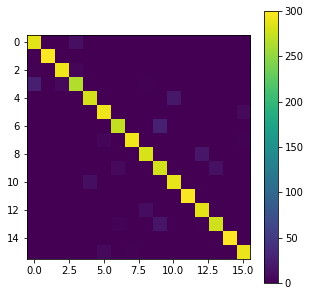

In [35]:
figure(figsize=(5,5))
imshow(confusion_matrix)
colorbar()

In [36]:
# the sum of the diagonal is related the accuracy:
np.sum(np.diag(confusion_matrix)) / (300 * 16) * 100.0

95.5625

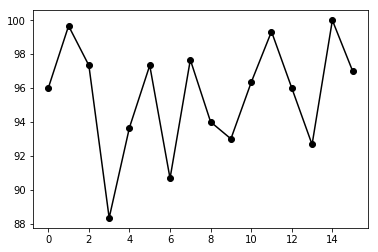

In [37]:
plot(np.diag(confusion_matrix) / 300.0 * 100.0, '-ok')

Interesting for **gesture design**

## The problem of false positives

False positives are gestures that are wrongly classified. For instance, I am performing a circle and the algorithm recognises a triangle, which means that it will trigger the wrong command. 

False positives can lead to frustration for a user and can lead to safety problem. 

To avoid False Positive, we want to classify a gesture based on the **model confidence** in its prediction.

This brings us to consider **probabilistic models** which can make a prediction and associates a likelihood to this prediction. 

For instance, say that the classifier can recognise circle/square/triangle. If the gesture input is a circle, the classifier will output a probability value to each class such as for instance 0.7 for circle, 0.2 for square, and 0.1 for triangle.

In [63]:
gestures = ['circle','square','triangle']
prob_over_gestures = [0.7, 0.2, 0.1]

<Container object of 3 artists>

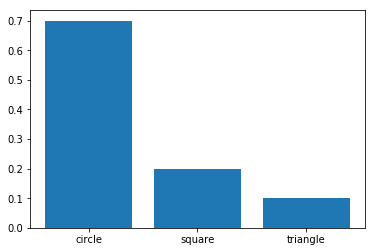

In [64]:
bar(gestures, prob_over_gestures)

In [65]:
print('index recognised gesture is:', np.argmax(prob_over_gestures))
print('which means:', gestures[np.argmax(prob_over_gestures)])

index recognised gesture is: 0
which means: circle


Let's inspect that more in details with the probabilistic model called **Gaussian Mixture Model**

In [1]:
from Lecture4lib.gmm import GMMC
from sklearn.model_selection import StratifiedKFold
from Lecture4lib.utils import load_one_dollar_ds
import numpy as np
dataset, labels = load_one_dollar_ds(resample=True)

In [2]:
splitter = StratifiedKFold(n_splits = 12)

dataset, labels = load_one_dollar_ds(resample=True)
dataset = np.resize(dataset, (4800, 100))

classes = list(np.unique(labels))
n_classes = len(classes)
confusion_matrix = np.zeros((n_classes, n_classes))

for train_index, test_index in splitter.split(dataset, labels):
    X_train = dataset[train_index]
    y_train = labels[train_index]
    X_test = dataset[test_index]
    y_test = labels[test_index]   
    
    classifier = GMMC()
    classifier.fit(X_train, y_train)
    
    for i, x_ in enumerate(X_test):
        predicted_label = classifier.predict(x_.reshape(1,-1))
        confusion_matrix[y_test[i], predicted_label] += 1

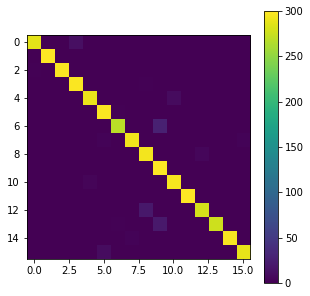

In [5]:
figure(figsize=(5,5))
imshow(confusion_matrix)
colorbar()

In [6]:
# the sum of the diagonal is related the accuracy:
np.sum(np.diag(confusion_matrix)) / (300 * 16) * 100.0

97.270833333333329

In [7]:
splitter = StratifiedKFold(n_splits = 12)

dataset, labels = load_one_dollar_ds(resample=True)
dataset = np.resize(dataset, (4800, 100))

classes = list(np.unique(labels))
n_classes = len(classes)
confusion_matrix = np.zeros((n_classes, n_classes))

good_candidates = 0
bad_candidates = 0

for train_index, test_index in splitter.split(dataset, labels):
    X_train = dataset[train_index]
    y_train = labels[train_index]
    X_test = dataset[test_index]
    y_test = labels[test_index]   
    
    classifier = GMMC()
    classifier.fit(X_train, y_train)
    
    for i, x_ in enumerate(X_test):
        probas = classifier.predict_proba(x_.reshape(1,-1))
        if (np.max(probas) > 0.999):
            pred_label = np.argmax(probas)
            confusion_matrix[y_test[i], pred_label] += 1
            good_candidates += 1
        else:
            bad_candidates += 1

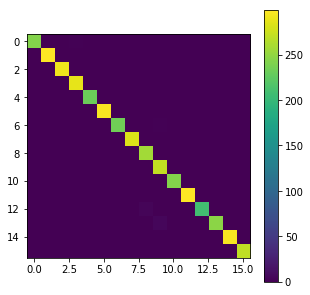

In [8]:
figure(figsize=(5,5))
imshow(confusion_matrix)
colorbar()

In [9]:
np.sum(np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)) / 16 * 100.0

99.535730212448087

In [10]:
# Percentage of used dropped data
bad_candidates / (bad_candidates + good_candidates) * 100.0

10.895833333333334

# Conclusions

What we have seen:
- Visualizing dataset
- Training a classifier on a dataset
- Testing a classifier with cross-validation
- On-class vs multi-class problem
- The case of gesture recognition
- Compare classifiers for gesture recognition
- Understand confusion in classification
- Beware fasle positives

___
About this material: copyright Baptiste Caramiaux (write me for any questions or use of this material [email](mailto:baptiste.caramiaux@lri.fr))
___